# 3. Imagen

In [78]:
#importar librerias
import numpy as np
from sklearn.decomposition import PCA
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

In [79]:
#cargar la imagen
image = Image.open('Messi.jpg').convert('L')  # Convertir a escala de grises
image = np.array(image)

In [80]:
#hacer que las dimensiones de la imagen sean divisibles por C
C = 8
height, width = image.shape
new_height = height - (height % C)
new_width = width - (width % C)
image = image[:new_height, :new_width]

In [81]:
#dividir la imagen en bloques de C x C
blocks = [image[i:i+C, j:j+C].flatten() for i in range(0, new_height, C) for j in range(0, new_width, C)]
X = np.array(blocks)

In [82]:
#lista de valores k
k_values = [1, 5, 10, 20, 50, 64]
mse_values = []  # Para almacenar los errores de reconstrucción

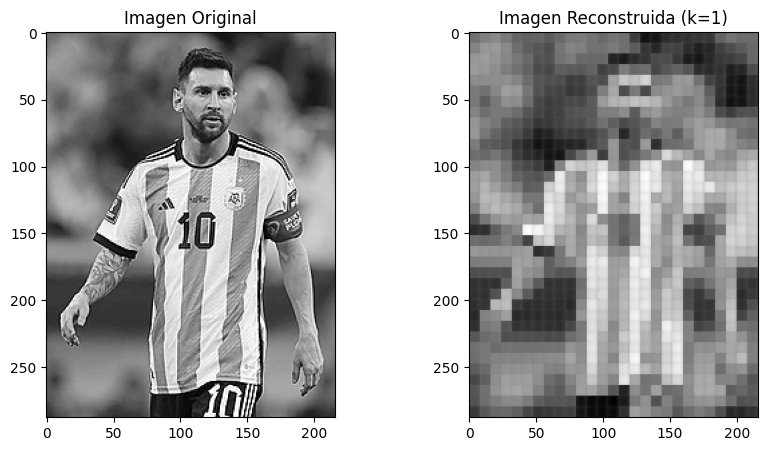

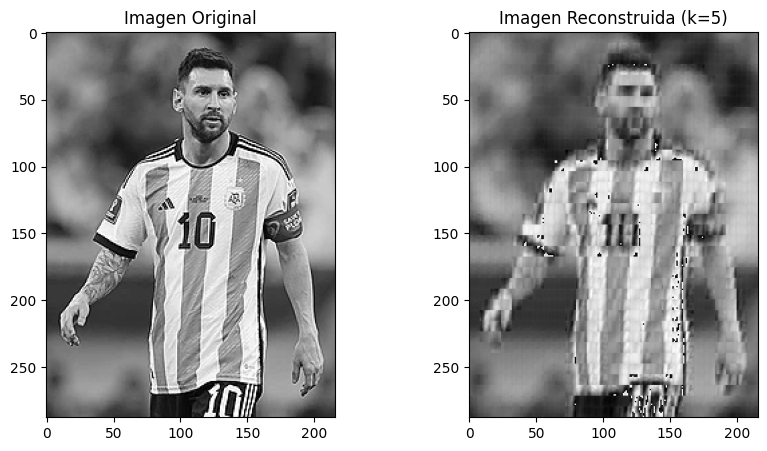

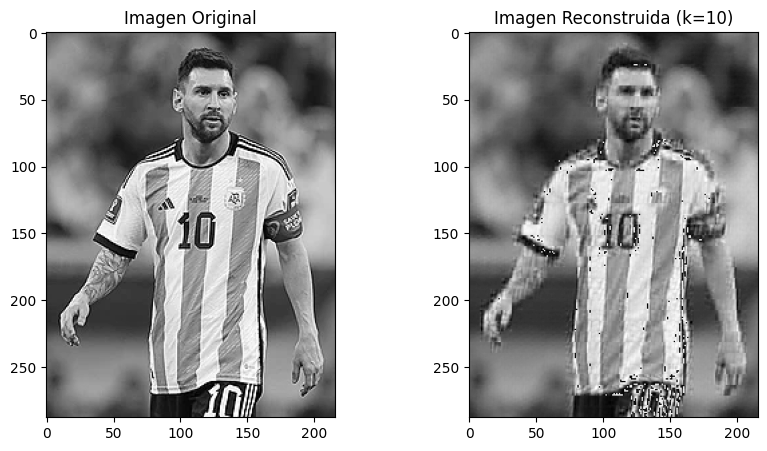

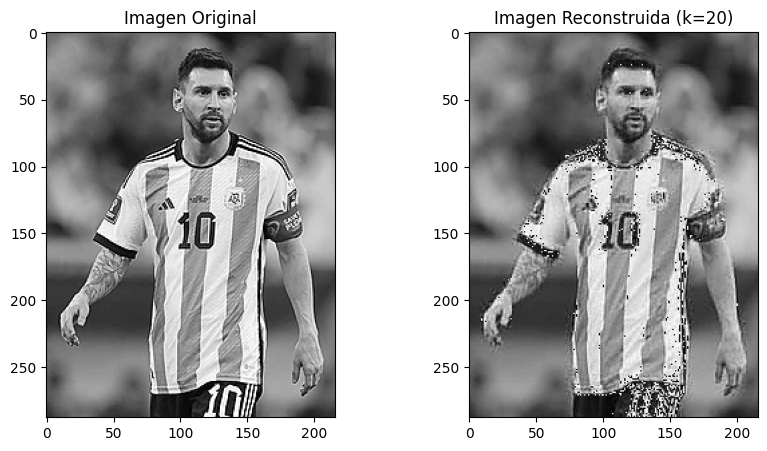

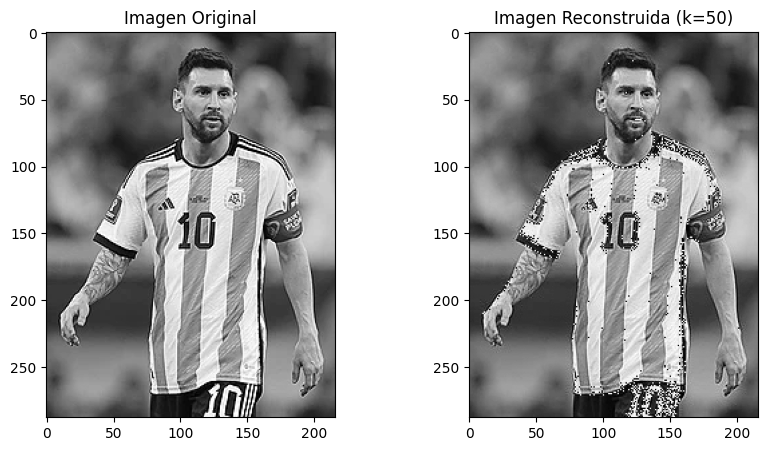

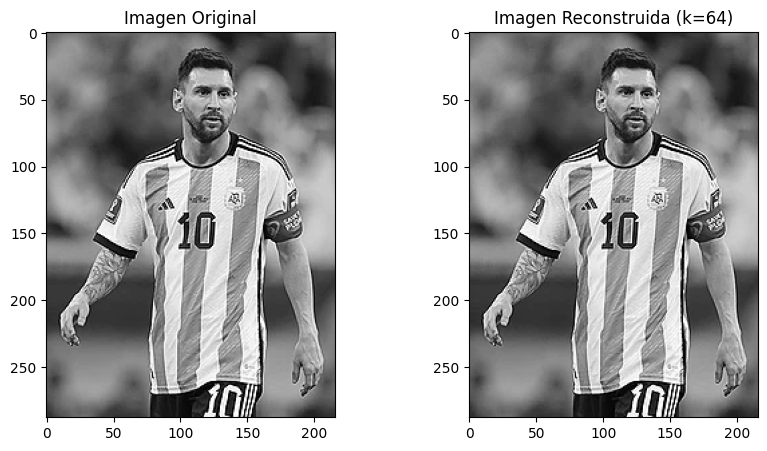

In [83]:
# Probar diferentes valores de k
for k in k_values:
    # Aplicar PCA
    pca = PCA(n_components=k)
    X_reduced = pca.fit_transform(X)
    
    # Reconstruir la imagen
    X_reconstructed = pca.inverse_transform(X_reduced)
    reconstructed_image = np.zeros_like(image)
    index = 0
    for i in range(0, new_height, C):
        for j in range(0, new_width, C):
            reconstructed_image[i:i+C, j:j+C] = X_reconstructed[index].reshape(C, C)
            index += 1
    
    # Calcular el error de reconstrucción (MSE)
    mse = np.mean((image - reconstructed_image) ** 2)
    mse_values.append(mse)
    
    # Mostrar la imagen reconstruida
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Imagen Original")
    plt.imshow(image, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title(f"Imagen Reconstruida (k={k})")
    plt.imshow(reconstructed_image, cmap='gray')
    plt.show()


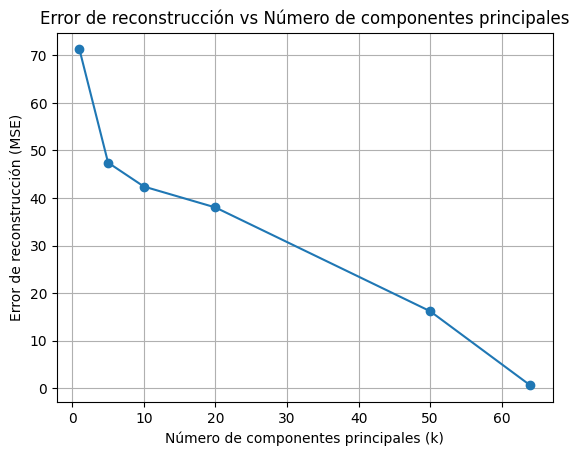

In [84]:
# Graficar el error de reconstrucción vs k
plt.figure()
plt.plot(k_values, mse_values, marker='o')
plt.xlabel('Número de componentes principales (k)')
plt.ylabel('Error de reconstrucción (MSE)')
plt.title('Error de reconstrucción vs Número de componentes principales')
plt.grid(True)
plt.show()

# 4. Sistema de Recomendación

In [85]:
#cargar datos
movies = pd.read_csv('./datasets/movies.csv')
ratings = pd.read_csv('./datasets/ratings.csv')

In [86]:
#crear matriz de usuarios vs películas
user_movie_matrix = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)

In [ ]:
#apllicar NNMF
model = NMF(n_components=20, init='random', random_state=42)
W = model.fit_transform(user_movie_matrix)  #preferencias de usuarios
H = model.components_  #características de películas

In [ ]:
#hacer recomendaciones
def recommend_movies(user_id, top_n=10):
    user_ratings = user_movie_matrix.loc[user_id].values
    predicted_ratings = np.dot(W[user_id-1], H)  #calificaciones
    recommended_movie_ids = np.argsort(predicted_ratings)[::-1][:top_n]  #top N películas
    return movies[movies['movieId'].isin(recommended_movie_ids)]

In [89]:
#ejemplo de recomendación para un usuario
user_id = 1
recommended_movies = recommend_movies(user_id)
print(f"Recomendaciones para el usuario {user_id}:")
print(recommended_movies)

Recomendaciones para el usuario 1:
      movieId                           title                        genres
191       224         Don Juan DeMarco (1995)          Comedy|Drama|Romance
442       507         Perfect World, A (1993)          Crime|Drama|Thriller
679       897  For Whom the Bell Tolls (1943)   Adventure|Drama|Romance|War
681       899      Singin' in the Rain (1952)        Comedy|Musical|Romance
683       901               Funny Face (1957)                Comedy|Musical
692       910         Some Like It Hot (1959)                  Comedy|Crime
696       914             My Fair Lady (1964)  Comedy|Drama|Musical|Romance
719       938                     Gigi (1958)                       Musical
1147     1502                   Kissed (1996)                 Drama|Romance
1416     1938        Lost Weekend, The (1945)                         Drama


In [90]:
#comparar con las películas mejor calificadas por el usuario
top_rated_movies = ratings[ratings['userId'] == user_id].sort_values(by='rating', ascending=False).head(10)
print(f"Películas mejor calificadas por el usuario {user_id}:")
print(movies[movies['movieId'].isin(top_rated_movies['movieId'])])

Películas mejor calificadas por el usuario 1:
      movieId                                        title  \
990      1291    Indiana Jones and the Last Crusade (1989)   
996      1298                  Pink Floyd: The Wall (1982)   
2028     2700  South Park: Bigger, Longer and Uncut (1999)   
2145     2858                       American Beauty (1999)   
2157     2872                             Excalibur (1981)   
2182     2899                    Gulliver's Travels (1939)   
2216     2944                      Dirty Dozen, The (1967)   
2218     2947                            Goldfinger (1964)   
2219     2948                 From Russia with Love (1963)   
3673     5060                 M*A*S*H (a.k.a. MASH) (1970)   

                            genres  
990               Action|Adventure  
996                  Drama|Musical  
2028      Animation|Comedy|Musical  
2145                 Drama|Romance  
2157             Adventure|Fantasy  
2182  Adventure|Animation|Children  
2216        

In [91]:
#similitud del coseno entre usuarios
user_similarity = cosine_similarity(W)  # W es la matriz de preferencias de usuarios obtenida con NNMF
user_similarity_df = pd.DataFrame(user_similarity, index=user_movie_matrix.index, columns=user_movie_matrix.index)

In [92]:
#encontrar los vecinos más cercanos
def find_top_neighbors(user_id, top_neigh=5):
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).index[1:top_neigh+1]
    return similar_users

In [93]:

#recomendaciones
def recommend_movies_based_on_neighbors(user_id, top_neigh=5, top_movies=10):
    #encontrar los vecinos más cercanos
    neighbors = find_top_neighbors(user_id, top_neigh)
    
    #películas mejor calificadas por los vecinos
    neighbor_ratings = user_movie_matrix.loc[neighbors]
    top_movies_from_neighbors = neighbor_ratings.mean(axis=0).sort_values(ascending=False).head(top_movies)
    
    #películas que el usuario no ha visto
    user_ratings = user_movie_matrix.loc[user_id]
    unseen_movies = top_movies_from_neighbors.index[~top_movies_from_neighbors.index.isin(user_ratings[user_ratings > 0].index)]
    
    return movies[movies['movieId'].isin(unseen_movies)]

In [94]:
#3 usuarios diferentes
user_ids = [1, 2, 3]

for user_id in user_ids:
    print(f"\nRecomendaciones para el usuario {user_id}:")
    recommended_movies = recommend_movies_based_on_neighbors(user_id, top_neigh=5, top_movies=10)
    print(recommended_movies[['movieId', 'title']])
    
    # Comparar con las películas mejor calificadas por el usuario
    top_rated_movies = ratings[ratings['userId'] == user_id].sort_values(by='rating', ascending=False).head(10)
    print(f"\nPelículas mejor calificadas por el usuario {user_id}:")
    print(movies[movies['movieId'].isin(top_rated_movies['movieId'])][['movieId', 'title']])


Recomendaciones para el usuario 1:
      movieId                                              title
2097     2791                                   Airplane! (1980)
2983     3996  Crouching Tiger, Hidden Dragon (Wo hu cang lon...

Películas mejor calificadas por el usuario 1:
      movieId                                        title
990      1291    Indiana Jones and the Last Crusade (1989)
996      1298                  Pink Floyd: The Wall (1982)
2028     2700  South Park: Bigger, Longer and Uncut (1999)
2145     2858                       American Beauty (1999)
2157     2872                             Excalibur (1981)
2182     2899                    Gulliver's Travels (1939)
2216     2944                      Dirty Dozen, The (1967)
2218     2947                            Goldfinger (1964)
2219     2948                 From Russia with Love (1963)
3673     5060                 M*A*S*H (a.k.a. MASH) (1970)

Recomendaciones para el usuario 2:
      movieId                      ti